In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [2]:
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <= 0.001):
            self.model.stop_training = True

In [3]:
def create_df(file):
    df = pd.read_csv(file,)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    return df

def segment_df(df, start_date: str, end_date: str):        
    data = df.loc[start_date:end_date]
    return data    


def resample_data(df, size: str):               # size will will specify weekly or monthly
    data = df.resample(size).agg({'Sales':'sum', 'Dollar to Pkr':'mean', 'Daily Cases':'sum'})
    return data

def resample_stock_data(df: pd.DataFrame):
    
    df_temp = df.copy(deep=True)

    df_temp.drop('Sales', inplace=True, axis=1)

    df_temp.drop('Average Discount', inplace=True, axis=1)
    df_temp.drop('Day', inplace=True, axis=1)
    df_temp.drop('Week Day', inplace=True, axis=1)
    df_temp.drop('Week End', inplace=True, axis=1)
    df_temp.drop('Hijri Dates', inplace=True, axis=1)

    # df_temp['Date'] = pd.to_datetime(df_temp['Date'], format="%Y-%m-%d")
    # df_temp.set_index('Date', inplace=True)
    df_temp = df_temp.resample('M').sum()

    for index, row in df_temp.iterrows():
        df_temp.loc[index, 'Year'] = index.year
        df_temp.loc[index, 'Month'] = index.month
        df_temp.loc[index, 'eid ul fitr'] = row['eid ul fitr']/30
        df_temp.loc[index, 'eid ul Adha'] = row['eid ul Adha']/30
        df_temp.loc[index, 'Muharrum'] = row['Muharrum']/30
        df_temp.loc[index, 'Wheat Harvest'] = row['Wheat Harvest']/30
        df_temp.loc[index, 'Cotton Harvest'] = row['Cotton Harvest']/30

    return df_temp

def moving_average(df, window_size, column_name, new_column_name):
    data = df
    data[new_column_name] = data[column_name].rolling(window=window_size).mean()
    return data

def view_df(df, head: bool=False, tail: bool=False):
    if head == False and tail == False:
        print(df)
    elif head == True:
        print(df.head(10))
    else:
        print(df.tail(10))

def line_plot(df, columns: list, color):
    for c in columns:
        plt.plot(df.index, df[c], color = color)
        plt.scatter(df.index, df[c], color = color)
        plt.show()

def replace_missing(df):
    data = df
    for column in data:
        data[column].interpolate(inplace = True)
    return data

def train_test_split(df, split):
    train_size = int(len(df)*split)
    train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]
    return train_dataset, test_dataset

def create_X_Y_train(training_df, testing_df, target_variable):
    X_train = training_df.drop(target_variable, axis = 1)
    y_train = training_df.loc[:,target_variable]
    
    X_test = testing_df.drop(target_variable, axis = 1)
    y_test = testing_df.loc[:,target_variable]

    return X_train, y_train, X_test, y_test

def scale_and_transform(x_train, y_train, x_test, y_test):
    scaler_x = MinMaxScaler(feature_range = (0,1))
    scaler_y = MinMaxScaler(feature_range = (0,1))
    input_scaler = scaler_x.fit(x_train)
    output_scaler = scaler_y.fit(y_train)
    train_y_norm = output_scaler.transform(y_train)
    train_x_norm = input_scaler.transform(x_train)
    test_y_norm = output_scaler.transform(y_test)
    test_x_norm = input_scaler.transform(x_test)

    return scaler_x, scaler_y, train_x_norm, train_y_norm, test_x_norm, test_y_norm

def create_dataset (x_norm, y_norm, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(x_norm)-time_steps):
        v = x_norm[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y_norm[i+time_steps])
    return np.array(Xs), np.array(ys)

def create_model_bilstm(units, loss, x_train, target_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units, activation = 'relu',                          
              return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units, return_sequences = True)))  #
    model.add(Bidirectional(LSTM(units = units, return_sequences = True)))  #
    model.add(Bidirectional(LSTM(units = units, return_sequences = True)))  #
    model.add(Bidirectional(LSTM(units = units, activation = 'relu', return_sequences = True)))
    model.add(Bidirectional(LSTM(units = units, activation = 'relu')))
    model.add(Dense(target_size, activation='relu'))
    #Compile model
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    logcosh = tf.keras.losses.LogCosh()
    model.compile(loss=loss, optimizer='adam')
    return model

def create_model(model_name, units, loss, x_train, target_size):
    model = Sequential()
    model.add(model_name (units = units, activation = 'relu', return_sequences = True,
                input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = target_size, activation='relu'))
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    logcosh = tf.keras.losses.LogCosh()
    #Compile model
    model.compile(loss=loss, optimizer='adam')
    return model


def fit_model(model, epochs, x_train, y_train):
    trainingStopCallback = haltCallback()
    # early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
    #                                            patience = 10)
    history = model.fit(x_train, y_train, epochs = epochs,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False,callbacks = trainingStopCallback
                        )
    return history

def plot_loss (history, name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.title(name)
    filename = 'loss ' + name
    plt.savefig(filename)
    # plt.show()

def inverse_transformation(scaler_y, y_train:np.ndarray, y_test:np.ndarray):
    y_test = scaler_y.inverse_transform(y_test)
    y_train = scaler_y.inverse_transform(y_train)
    return y_train, y_test

def model_fitting(model, x_train, scaler_y):

    fitting = model.predict(x_train)
    return scaler_y.inverse_transform(fitting)

def plot_fit(fit, y_train, name, column_name, epochs):
    plt.figure(figsize=(10, 6))
    range_future = len(fit)
    plt.plot(np.arange(range_future), np.array(y_train), 
             label='Training Data')     
    plt.plot(np.arange(range_future),np.array(fit),
            label='Model Fit ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title(column_name)
    filename = column_name + ' model fitting ' + str(epochs)
    # plt.savefig(filename)
    plt.show()

def prediction(model, x_test, scaler_y):
    prediction = model.predict(x_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

def plot_future(prediction, y_test, name, column_name, epochs):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test Data')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (week)')
    plt.ylabel('Sales')
    plt.title(column_name)
    filename = column_name + ' prediction ' + str(epochs)
    # plt.savefig(filename)
    plt.show()

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [6]:
filename = '..\Data\Monthly_Stocks_Data\category a228a-fix with features.csv'

data = create_df(filename)
# view_df(data)

training_df, testing_df = train_test_split(data, 0.8)

target_brands = []
for column in data.columns:
    if "brand" in column:
        target_brands.append(column)
x_train, y_train, x_test, y_test = create_X_Y_train(training_df, testing_df, target_brands)
scaler_x, scaler_y, train_x_norm, train_y_norm, test_x_norm, test_y_norm = scale_and_transform(x_train, y_train, x_test, y_test)

TIME_STEPS = 3
x_test_3d, y_test_3d = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
x_train_3d, y_train_3d = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)

model_bilstm = create_model_bilstm(128, 'huber_loss', x_train_3d, len(target_brands))
model_lstm = create_model(LSTM, 128, 'huber_loss', x_train_3d, len(target_brands))

epochs = 300

history_bilstm = fit_model(model_bilstm, epochs , x_train_3d, y_train_3d)
history_lstm = fit_model(model_lstm, epochs, x_train_3d, y_train_3d)


Epoch 1/300
2/2 [==============================] - 22s 4s/step - loss: 0.0529 - val_loss: 0.0445
Epoch 2/300
2/2 [==============================] - 0s 46ms/step - loss: 0.0521 - val_loss: 0.0438
Epoch 3/300
2/2 [==============================] - 0s 53ms/step - loss: 0.0511 - val_loss: 0.0429
Epoch 4/300
2/2 [==============================] - 0s 54ms/step - loss: 0.0501 - val_loss: 0.0418
Epoch 5/300
2/2 [==============================] - 0s 99ms/step - loss: 0.0488 - val_loss: 0.0404
Epoch 6/300
2/2 [==============================] - 0s 56ms/step - loss: 0.0472 - val_loss: 0.0387
Epoch 7/300
2/2 [==============================] - 0s 64ms/step - loss: 0.0453 - val_loss: 0.0373
Epoch 8/300
2/2 [==============================] - 0s 53ms/step - loss: 0.0437 - val_loss: 0.0371
Epoch 9/300
2/2 [==============================] - 0s 52ms/step - loss: 0.0437 - val_loss: 0.0364
Epoch 10/300
2/2 [==============================] - 0s 50ms/step - loss: 0.0437 - val_loss: 0.0360
Epoch 11/300
2/2 [==

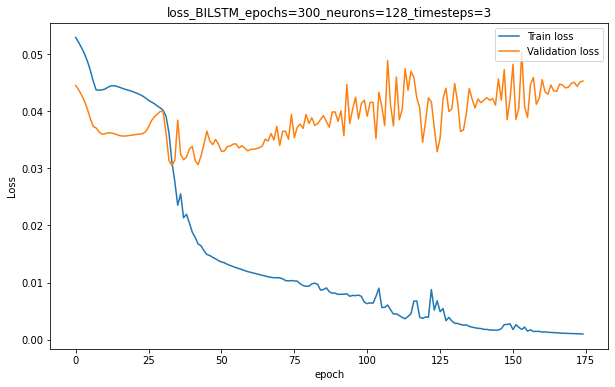

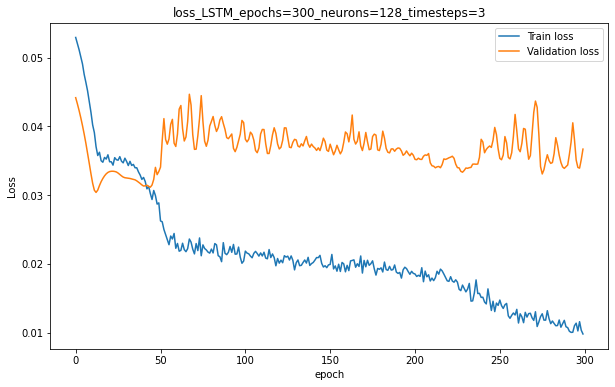

In [21]:
from plotting_helper_functions import *


temp = filename.split()
fname = temp[0] + '_' + temp[1].split('-')[0]

path = '../Results/Stock Predictions/' + fname
if not os.path.exists(path):
    os.makedirs(path)


plot_loss_stocks (history_bilstm, 'BILSTM', path, epochs, 128, 3)       # hassam comment this line to run forecast onli
plot_loss_stocks (history_lstm, 'LSTM', path, epochs, 128, 3)           # hassam comment this line to run forecast onli


In [16]:
y_train, y_test = inverse_transformation(scaler_y, y_train_3d, y_test_3d)

In [17]:
bilstm_fit = model_fitting(model_bilstm, x_train_3d, scaler_y)
lstm_fit = model_fitting(model_lstm, x_train_3d, scaler_y)


In [18]:
print(bilstm_fit)

[[2.39252639e+00 0.00000000e+00 4.29092073e+00 0.00000000e+00
  0.00000000e+00]
 [9.70957100e-01 0.00000000e+00 2.07458472e+00 0.00000000e+00
  0.00000000e+00]
 [2.90358019e+00 0.00000000e+00 3.79990435e+00 0.00000000e+00
  0.00000000e+00]
 [1.01091585e+01 7.19891250e-01 8.11097741e-01 0.00000000e+00
  0.00000000e+00]
 [6.57715654e+00 0.00000000e+00 5.03823757e+00 7.10119605e-02
  1.37081698e-01]
 [8.93006039e+00 3.99156380e+00 4.02497625e+00 9.82567251e-01
  0.00000000e+00]
 [4.84881401e+00 9.31271255e-01 1.95141041e+00 0.00000000e+00
  0.00000000e+00]
 [2.30843234e+00 0.00000000e+00 3.05538177e+00 0.00000000e+00
  0.00000000e+00]
 [7.04889631e+00 0.00000000e+00 1.37248683e+00 9.33847278e-02
  0.00000000e+00]
 [3.75562644e+00 0.00000000e+00 1.15925264e+00 1.02974296e-01
  0.00000000e+00]
 [5.63685703e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [9.86837578e+00 0.00000000e+00 4.11997080e+00 1.07475674e+00
  0.00000000e+00]
 [6.74220514e+00 0.00000000e+00 2.904769

In [19]:
print(lstm_fit)

[[ 3.6867561   1.1509616   2.990908    0.54939926  0.        ]
 [ 1.2502568   1.0026584   2.0404828   0.30301726  0.        ]
 [ 3.045374    1.0828319   3.1382399   0.47697783  0.        ]
 [ 8.313318    1.2936184   1.7665235   0.9914689   0.31974792]
 [ 8.366654    1.0611559   3.6181035   0.8639674   0.        ]
 [ 9.615635    1.3740866   3.1029572   1.0842261   0.        ]
 [ 4.2399464   0.8672539   1.4224365   0.5128329   0.        ]
 [ 3.6942387   0.8102104   1.709263    0.44583994  0.        ]
 [ 5.951666    1.0998107   1.3554081   0.7380098   0.        ]
 [ 3.3410378   0.6663637   0.9596989   0.40331063  0.        ]
 [ 3.4945116   0.6363257   0.71188104  0.44941628  0.        ]
 [ 8.638895    1.206355    2.9814744   0.94728744  0.        ]
 [ 7.82726     1.2621932   2.5187423   0.9146645   0.        ]
 [ 1.5608183   1.4026277   4.038922    0.50965726  0.        ]
 [ 2.8508132   0.5508688   0.498716    0.37991202  0.        ]
 [ 9.170596    1.0983007   0.8869064   1.3081638   1.34

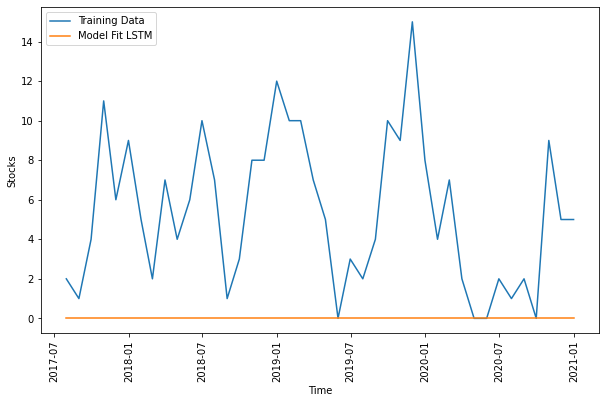

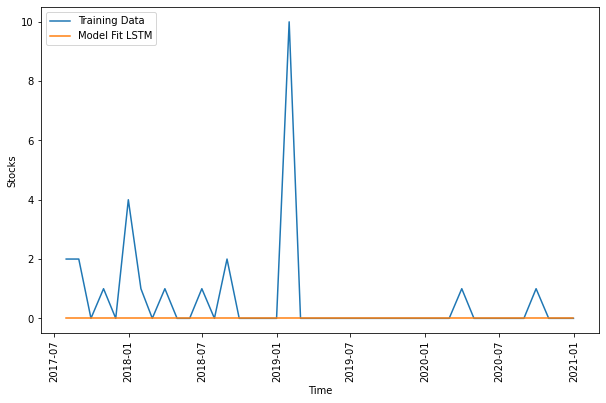

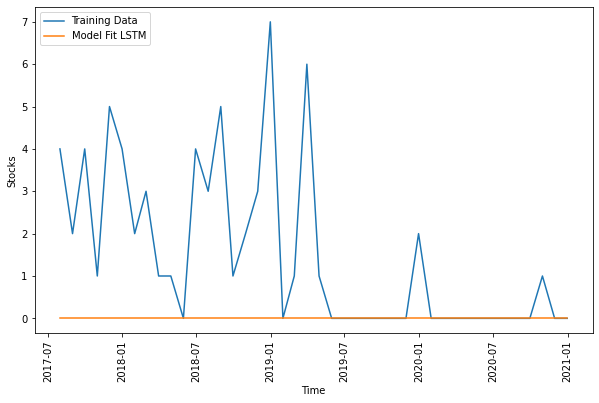

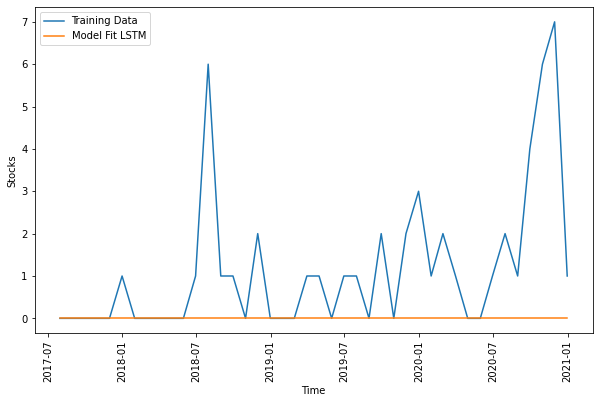

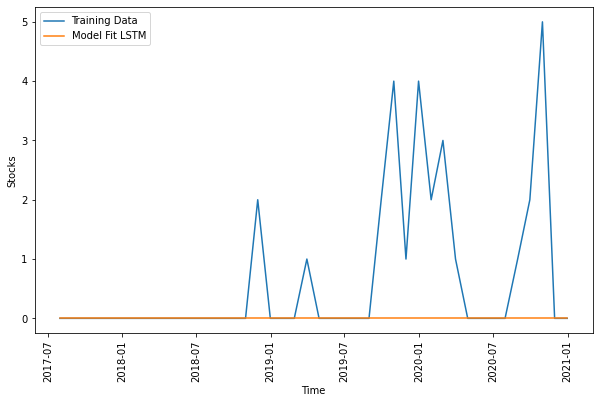

In [22]:

training_dates = training_df.index.tolist()[-training_df.shape[0]:]
    
# plot_fit_Stocks(training_dates, target_brands, bilstm_fit, y_train, 'BiLSTM', path, epochs, 128, 3)    # hassam comment this line to run forecast onli
a = plot_fit_Stocks(training_dates, target_brands, lstm_fit, y_train, 'LSTM', path, epochs, 128, 3)        # hassam comment this line to run forecast onli


In [23]:
print(a)

None
